In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-03-22 16:29:20.671680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 16:29:27.828051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 16:29:27.833573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 16:29:29.725505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 16:29:34.576783: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-22 16:30:34.626526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:30:34.864964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:30:34.865007: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import keras
print(keras.__version__)

3.0.0


In [ ]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(train_ds, validation_ds, test_ds), info = tfds.load(
    "cifar10",
    # Reserve 10% for validation and 10% for test
    split=["train[:20%]", "train[20%:25%]", "train[25%:30%]"],
    as_supervised=True,  # Include labels
    with_info=True
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

2024-03-22 16:30:58.345504: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:30:58.345584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:30:58.345601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:30:58.530372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:30:58.530436: I external/local_xla/xla/stream_executor

Number of training samples: 10000
Number of validation samples: 2500
Number of test samples: 2500


In [4]:
num_classes = info.features["label"].num_classes
class_names = info.features["label"].names
print(num_classes)
print(class_names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


2024-03-22 16:31:06.627721: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


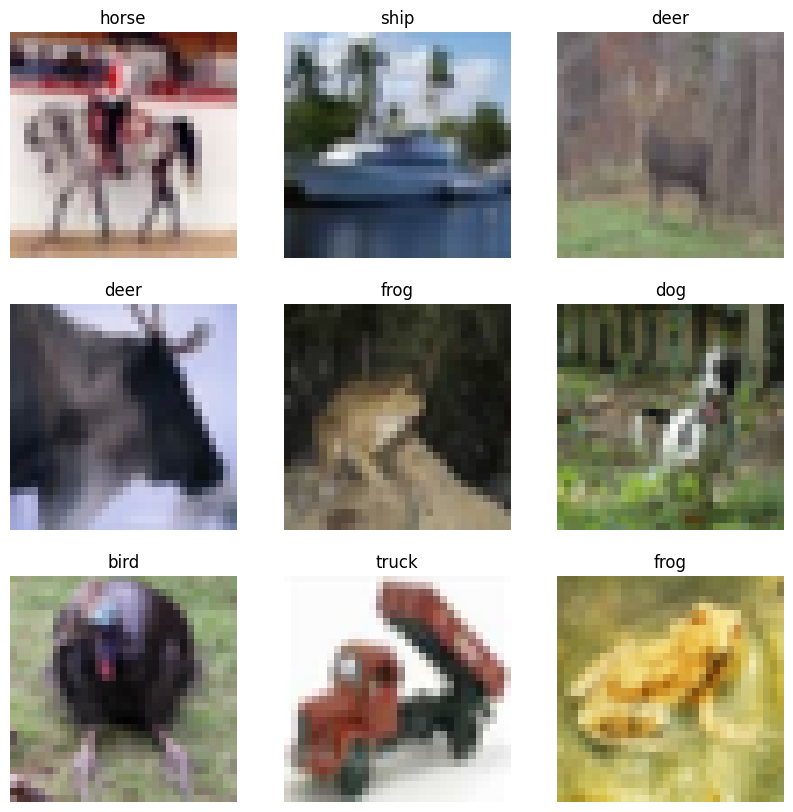

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(info.features["label"].names[label])
    plt.axis("off")

In [6]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [7]:
augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

augmenter = keras.Sequential(
    [
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomTranslation(0.1,0.1),
        keras.layers.RandomZoom(0.1,0.1)
    ],
)


def data_augmentation(x):
    # for layer in augmentation_layers:
    #     x = layer(x)
    x = augmenter(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [8]:
batch_size = 32

train_batches = train_ds.batch(batch_size).prefetch(1)
validation_batches = validation_ds.batch(batch_size).prefetch(1)
test_batches = test_ds.batch(batch_size).prefetch(1)

2024-03-22 16:31:19.415776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


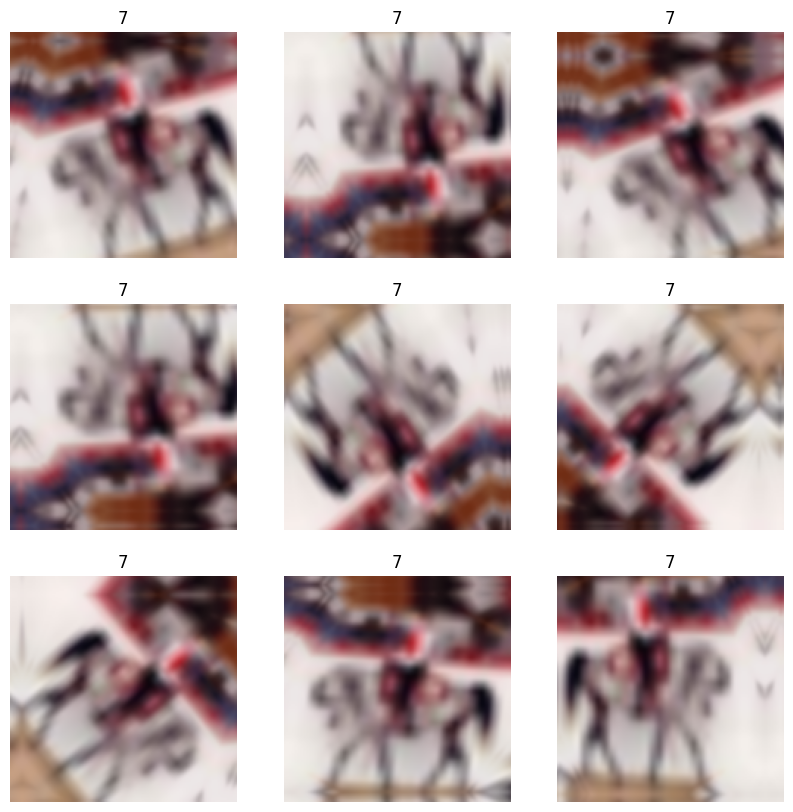

In [9]:
import numpy as np
for image, label in train_ds.take(1):    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(image)
        plt.imshow(np.array(augmented_image).astype("int32"))
        plt.title(int(label))
        plt.axis("off")

In [10]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃ Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)       │ 20,861… │   N   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)             │       0 │   -   │
│ (GlobalAveragePooling2D)    │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)             │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dense (Dense)               │ (None, 10)               │  20,490 │   Y   │
└─────────────────────────────┴──────────────────────────┴─────────┴───────┘

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [11]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

epochs = 20
print("Fitting the top layer of the model")
model.fit(train_batches, epochs=epochs, validation_data=validation_batches)

Fitting the top layer of the model
Epoch 1/20


2024-03-22 16:31:37.695739: I external/local_xla/xla/service/service.cc:168] XLA service 0x559fb1f12540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 16:31:37.695802: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-03-22 16:31:38.177808: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 16:31:39.599133: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1711121523.809917    2326 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 379ms/step - loss: 1.5447 - sparse_categorical_accuracy: 0.4539 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.7864
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 282ms/step - loss: 1.0904 - sparse_categorical_accuracy: 0.6167 - val_loss: 0.6160 - val_sparse_categorical_accuracy: 0.7944
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 292ms/step - loss: 0.9904 - sparse_categorical_accuracy: 0.6571 - val_loss: 0.5832 - val_sparse_categorical_accuracy: 0.8048
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 298ms/step - loss: 0.9804 - sparse_categorical_accuracy: 0.6556 - val_loss: 0.5662 - val_sparse_categorical_accuracy: 0.8072
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 311ms/step - loss: 0.9374 - sparse_categorical_accuracy: 0.6783 - val_loss: 0.5688 - val_sparse_categorical_accuracy: 0.8056
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 312ms/step - loss: 0.9364 - sparse_categorical_accuracy: 0.6770 - val_loss: 0.5779 - val_sparse_categorical_accuracy: 0.8

In [12]:
import os
model.save(os.path.join(os.getcwd(), "models", "model_cifar_adam.keras"))

In [13]:
print(model.history.history)
print(model.history.__dir__())
print(model.history.epoch)

{'loss': [1.302768588066101, 1.062697410583496, 1.0012410879135132, 0.9726421236991882, 0.9527144432067871, 0.9486725330352783, 0.9358417391777039, 0.9367246627807617, 0.9356331825256348, 0.9172279238700867, 0.9030479788780212, 0.9094502329826355, 0.9187918305397034, 0.8905367851257324, 0.9044222831726074, 0.8730742931365967, 0.9003797173500061, 0.8949505090713501, 0.8751384615898132, 0.8828692436218262], 'sparse_categorical_accuracy': [0.5468000173568726, 0.6283000111579895, 0.6553000211715698, 0.6621999740600586, 0.6733999848365784, 0.676800012588501, 0.6791999936103821, 0.6754000186920166, 0.6794000267982483, 0.685699999332428, 0.6876999735832214, 0.6886000037193298, 0.6789000034332275, 0.6920999884605408, 0.6883000135421753, 0.6938999891281128, 0.6873999834060669, 0.6891999840736389, 0.7014999985694885, 0.6905999779701233], 'val_loss': [0.6495494842529297, 0.6160451173782349, 0.5832391381263733, 0.5661783814430237, 0.5688126683235168, 0.5778703689575195, 0.5648186802864075, 0.56954

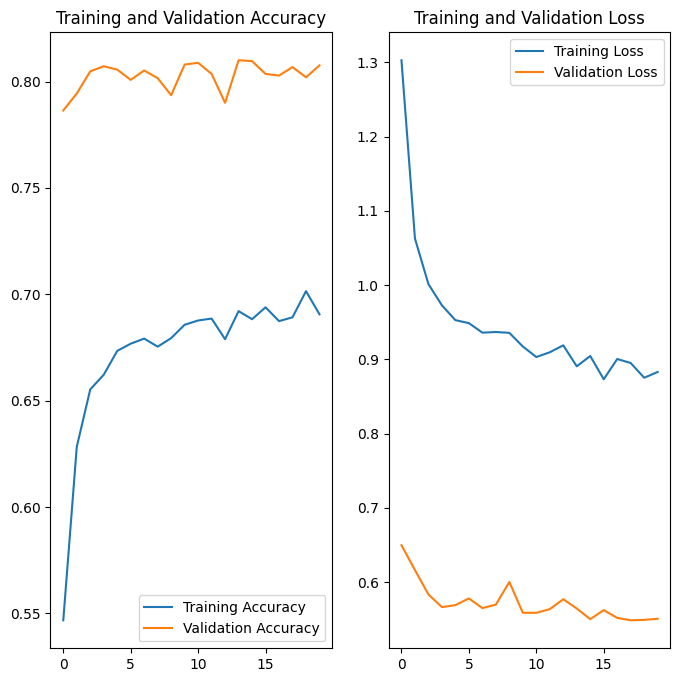

In [14]:
def plot_hist(hist):
    acc = hist.history['sparse_categorical_accuracy']
    val_acc = hist.history['val_sparse_categorical_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = hist.epoch

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


plot_hist(model.history)

In [15]:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.5476 - sparse_categorical_accuracy: 0.7996
Test accuracy : 0.8080000281333923


In [16]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [23]:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.5476 - sparse_categorical_accuracy: 0.7996
Test accuracy : 0.8080000281333923


In [24]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_fine_tune = model  
model_fine_tune.summary(show_trainable=True)

model_fine_tune.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs
print("Fitting the end-to-end model")
model_fine_tune.fit(train_batches, epochs=total_epochs,
                         initial_epoch=20, validation_data=validation_batches)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃ Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)       │ 20,861… │   Y   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)             │       0 │   -   │
│ (GlobalAveragePooling2D)    │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)             │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dense (Dense)               │ (None, 10)               │  20,490 │   Y   │
└─────────────────────────────┴──────────────────────────┴─────────┴───────┘

 Total params: 20,881,970 (79.66 MB)

 Trainable params: 9,498,834 (36.24 MB)

 Non-trainable params: 11,383,136 (43.42 MB)

Fitting the end-to-end model
Epoch 21/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 385ms/step - loss: 1.3738 - sparse_categorical_accuracy: 0.5571 - val_loss: 0.8214 - val_sparse_categorical_accuracy: 0.7304
Epoch 22/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 108s 344ms/step - loss: 1.1344 - sparse_categorical_accuracy: 0.6265 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.7728
Epoch 23/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 336ms/step - loss: 1.0262 - sparse_categorical_accuracy: 0.6575 - val_loss: 0.5976 - val_sparse_categorical_accuracy: 0.8004
Epoch 24/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 362ms/step - loss: 0.9591 - sparse_categorical_accuracy: 0.6779 - val_loss: 0.6488 - val_sparse_categorical_accuracy: 0.7960
Epoch 25/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 316ms/step - loss: 0.9114 - sparse_categorical_accuracy: 0.6918 - val_loss: 0.5933 - val_sparse_categorical_accuracy: 0.8112
Epoch 26/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 324ms/step - loss: 0.8486 - sparse_categorical_accuracy: 0.7091 - val_

In [25]:
model_fine_tune.save(os.path.join(os.getcwd(), "models", "model_cifar_adam_ft.keras"))

In [27]:
loss, accuracy = model_fine_tune.evaluate(test_batches)
print('Test accuracy :', accuracy)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.4681 - sparse_categorical_accuracy: 0.8441
Test accuracy : 0.8432000279426575
